In [67]:
%matplotlib inline
%load_ext autoreload
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
from requests import get
#from tabulate import tabulate
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
#%aimport utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Table of content

1. [Data Acquisition](#data_acqui)
    * [Loading](#loading)
    * [Cleaning](#cleaning)
        * [Transition](#c_trans)
        * [Demographic](#c_demo)
        * [Product](#c_prod)
    * [Saving files](#saving)
2. [Exploration](#exploration)
    * [Getting sense of the data](#sense)
        * [Feature presentation](#feat_pres)
            * [Transition](#fp_tran)
            * [Demographic](#fp_demo)
            * [Product](#fp_prod)
        * [Feature range](#ft_range)
            * [Transition](#ft_tran)
            * [Demographic](#ft_demo)
            * [Product](#ft_prod)
        * [Distributions](#distributions)
            * [Transition](#d_tran)
            * [Demographic](#d_demo)
            * [Product](#d_prod)
        * [Outliers analysis](#outliers)
3. [Exploitation (work in progress...)](#explo)

<a id=data_acqui></a>
# 1. Data Acquisition

<a id=loading></a>
## Loading

In [68]:
dfList = []
for r, d, f in os.walk('../data/dunnhumby - The Complete Journey CSV/'):
    for file in f:
        if '.csv' in file:
            print(file)
            dfList.append(pd.read_csv(os.path.join(r, file)))

coupon_redempt.csv
hh_demographic.csv
causal_data.csv
product.csv
coupon.csv
campaign_desc.csv
campaign_table.csv
transaction_data.csv


In [69]:
hh_demographic_df = dfList[1].copy()
product_df = dfList[3].copy()
transaction_data_df = dfList[7].copy()


In [70]:
# This table contains all products purchased by households within this study. Each line found in
# this table is essentially the same line that would be found on a store receipt.
transaction_data_df.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [71]:
# This table contains demographic information for a portion of households. Due to nature of the
# data, the demographic information is not available for all households.
hh_demographic_df.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [72]:
# This table contains information on each product sold such as type of product, national or
# private label and a brand identifier.
product_df.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


<a id=cleaning></a>
## Cleaning

<a id=c_trans></a>
### Transactions

In [73]:
transaction_data_df.dtypes

household_key          int64
BASKET_ID              int64
DAY                    int64
PRODUCT_ID             int64
QUANTITY               int64
SALES_VALUE          float64
STORE_ID               int64
RETAIL_DISC          float64
TRANS_TIME             int64
WEEK_NO                int64
COUPON_DISC          float64
COUPON_MATCH_DISC    float64
dtype: object

In [74]:
# Transaction df is clean
print("Is there any NaN in transaction table: %s" %transaction_data_df.isna().any().any())

Is there any NaN in transaction table: False


In [75]:
# Lowercase all column names
transaction_data_df.columns = map(str.lower, transaction_data_df.columns)

In [76]:
# Set timestamp to the trans_time feature
transaction_data_df.trans_time = transaction_data_df.trans_time.astype(str)
trans_time_tmp = pd.to_datetime(transaction_data_df\
                                .trans_time.apply(lambda val: (4 - len(val)) * '0' + val if (len(val) < 4) else val), format='%H%M')
transaction_data_df.trans_time = trans_time_tmp.apply(lambda x: x.time())


<a id=c_demo></a>
## Demographic

In [77]:
# Every feature but house_hold key is an object. The object type is not helpful. We
# must cast it to categorical data.
hh_demographic_df.dtypes

AGE_DESC               object
MARITAL_STATUS_CODE    object
INCOME_DESC            object
HOMEOWNER_DESC         object
HH_COMP_DESC           object
HOUSEHOLD_SIZE_DESC    object
KID_CATEGORY_DESC      object
household_key           int64
dtype: object

#### INCOME_DESC

In [78]:
# Cast and set order
hh_demographic_df['INCOME_DESC'] = hh_demographic_df['INCOME_DESC'].astype('category')
hh_demographic_df.INCOME_DESC = hh_demographic_df.INCOME_DESC.cat.\
                                reorder_categories(['Under 15K', '15-24K','25-34K', '35-49K', '50-74K','75-99K', '100-124K','125-149K','150-174K', '175-199K', '200-249K', '250K+'], ordered=True)

#### KID_CATEGORY_DESC 

In [79]:
# Cast and set order
hh_demographic_df.KID_CATEGORY_DESC = hh_demographic_df.KID_CATEGORY_DESC.astype('category')
hh_demographic_df.KID_CATEGORY_DESC.cat.reorder_categories(['1', '2', '3+', 'None/Unknown']\
                                                          , ordered=True, inplace=True)

#### HOMEOWNER_DESC

In [80]:
# Casting
hh_demographic_df.HOMEOWNER_DESC = hh_demographic_df.HOMEOWNER_DESC.astype('category')

#### HH_COMP_DESC

In [81]:
# Casting
hh_demographic_df.HH_COMP_DESC = hh_demographic_df.HH_COMP_DESC.astype('category')

#### AGE_DESC

In [82]:
# Cast and set order
hh_demographic_df.AGE_DESC = hh_demographic_df.AGE_DESC.astype('category')
hh_demographic_df.AGE_DESC.cat\
                    .reorder_categories(['19-24', '25-34', '35-44', '45-54', '55-64', '65+'], ordered=True, inplace=True)

#### HOUSEHOLD_SIZE_DESC

In [83]:
# Cast and set order
hh_demographic_df.HOUSEHOLD_SIZE_DESC = hh_demographic_df.HOUSEHOLD_SIZE_DESC.astype('category')
hh_demographic_df.HOUSEHOLD_SIZE_DESC.cat.reorder_categories(\
                        ['1', '2', '3', '4', '5+'], ordered=True, inplace=True)

#### MARITAL_STATUS_CODE

In [84]:
# Cast
hh_demographic_df.MARITAL_STATUS_CODE = hh_demographic_df.MARITAL_STATUS_CODE.astype('category')

### Checking missing values

In [85]:
# Demographic df is clean
print("Is there any NaN in transaction table: %s" %hh_demographic_df.isna().any().any())

Is there any NaN in transaction table: False


In [86]:
# Lowercase all column names
hh_demographic_df.columns = map(str.lower, hh_demographic_df.columns)

<a id=c_prod></a>
## Product

In [87]:
product_df.dtypes

PRODUCT_ID               int64
MANUFACTURER             int64
DEPARTMENT              object
BRAND                   object
COMMODITY_DESC          object
SUB_COMMODITY_DESC      object
CURR_SIZE_OF_PRODUCT    object
dtype: object

In [88]:
# Casting
product_df.DEPARTMENT = product_df.DEPARTMENT.astype('category')
product_df.BRAND = product_df.BRAND.astype('category')
product_df.COMMODITY_DESC = product_df.COMMODITY_DESC.astype('category')
product_df.SUB_COMMODITY_DESC = product_df.SUB_COMMODITY_DESC.astype('category')
product_df.CURR_SIZE_OF_PRODUCT = product_df.CURR_SIZE_OF_PRODUCT.astype('category')

In [89]:
# Lowercase all column names
product_df.columns = map(str.lower, product_df.columns)

In [90]:
# Product df is clean
print("Is there any NaN in transaction table: %s" %product_df.isna().any().any())

Is there any NaN in transaction table: False


<a id=saving></a>
## Saving files

In [91]:
product_df.set_index('product_id', inplace=True)

In [92]:
hh_demographic_df.set_index('household_key', inplace=True)

In [93]:
# We assume here that a transaction is uniquely identifiied by the set of 3 features:
# household_keay | BASKET_ID | PRODUCT_ID
transaction_data_df.set_index(['household_key', 'basket_id', 'product_id'], inplace=True)

In [94]:
# This is verified by the following test
print("Transaction dataframe index is unique: %s" % transaction_data_df.index.is_unique)

Transaction dataframe index is unique: True


In [95]:
product_df.to_pickle('../data/preprocessed_data/product.pkl')
transaction_data_df.to_pickle('../data/preprocessed_data/transaction.pkl')
hh_demographic_df.to_pickle('../data/preprocessed_data/demographic.pkl')

<a id=exploration></a>
# 2. Exploration

In [96]:
# Loading clean data
product_df = pd.read_pickle('../data/preprocessed_data/product.pkl')
transaction_df = pd.read_pickle('../data/preprocessed_data/transaction.pkl')
transaction_df.trans_time = pd.to_datetime(transaction_df.trans_time, format='%H:%M:%S').dt.time
demographic_df = pd.read_pickle('../data/preprocessed_data/demographic.pkl')

In [97]:
transaction_df.head(1)

,,,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
household_key,basket_id,product_id,,,,,,,,,
2375,26984851472,1004906,1,1,1.39,364,-0.6,16:31:00,1,0.0,0.0


<a id=sense></a>
## Getting a sense of the data

<a id=feat_pres></a>
### Features presentation

For some features whose sense are not easy to grasp, we give some insights

In [98]:
def print_index_columns(df):
    '''
        Present the index and the features of the DataFrame
    '''
    
    print("index: ", " | ".join(list(df.index.names)))
    print("features: ")
    for idx, col in enumerate(df.columns.tolist()):
        print("\t %i) %s" % (idx,col))

<a id=fp_tran></a>
#### Transaction

In [99]:
print_index_columns(transaction_df)

index:  household_key | basket_id | product_id
features: 
	 0) day
	 1) quantity
	 2) sales_value
	 3) store_id
	 4) retail_disc
	 5) trans_time
	 6) week_no
	 7) coupon_disc
	 8) coupon_match_disc


*day:*
> from 1 to 711, corresponds to the daytime in the *two year long* study

*sales_value:*

> amount of dollars retailer receives from sale. It's not the price paid by the customer. If a customer use a coupon, he will pay less and the retailer will be reinboursed by the manufacturer.

*retail_disc:*
> Discount applied due to retailer's loyalty card program

*coupon_disc:*
> Discount applied due to manufacturer coupon.

<a id=fp_demo></a>
#### Demographic

In [100]:
print_index_columns(demographic_df)

index:  household_key
features: 
	 0) age_desc
	 1) marital_status_code
	 2) income_desc
	 3) homeowner_desc
	 4) hh_comp_desc
	 5) household_size_desc
	 6) kid_category_desc


*hh_comp_desc:*
> Household composition

*kid_category_desc:*
> Number of children present in the household. If 3 or more children is given by '3+'

<a id=fp_prod></a>
#### Product

In [101]:
print_index_columns(product_df)

index:  product_id
features: 
	 0) manufacturer
	 1) department
	 2) brand
	 3) commodity_desc
	 4) sub_commodity_desc
	 5) curr_size_of_product


*curr_size_of_product:*
> Indicates package size (not available for all products)

*brand:*
> * A *national* brand is the brand of a product that is distributed nationally under a brand name.
> * A *private* label products are those manufactured by one company for sale under another company's brand.

<a id=ft_range></a>
### Feature range

This section expects to give a sense of the range in which our data is. For **numerical** values, we show the *minimum* and *maximum* values. For **categorical**, we present important statistics as follows: *count, unique, top, freq*. When the number of categories is not too large we also display it.

<a id=ft_tran></a>
#### Transaction

In [102]:
transaction_df.describe(exclude='category').loc[['min','max']]

,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
min,1.0,0.0,0.0,1.0,-180.00,NaN,1.0,-55.93,-7.7
max,711.0,89638.0,840.0,34280.0,3.99,NaN,102.0,0.00,0.0


<a id=ft_demo></a>
#### Demographic

In [103]:
demographic_df.describe()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
count,801,801,801,801,801,801,801
unique,6,3,12,5,6,5,4
top,45-54,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown
freq,288,344,192,504,255,318,558


In [104]:
for col in demographic_df:
    print("%s values:" % col)
    print(demographic_df[col].unique().sort_values().tolist(), end='\n\n')

age_desc values:
['19-24', '25-34', '35-44', '45-54', '55-64', '65+']

marital_status_code values:
['A', 'U', 'B']

income_desc values:
['Under 15K', '15-24K', '25-34K', '35-49K', '50-74K', '75-99K', '100-124K', '125-149K', '150-174K', '175-199K', '200-249K', '250K+']

homeowner_desc values:
['Homeowner', 'Unknown', 'Renter', 'Probable Renter', 'Probable Owner']

hh_comp_desc values:
['2 Adults No Kids', '2 Adults Kids', 'Single Female', 'Unknown', 'Single Male', '1 Adult Kids']

household_size_desc values:
['1', '2', '3', '4', '5+']

kid_category_desc values:
['1', '2', '3+', 'None/Unknown']



<a id=ft_prod></a>
#### Product

In [105]:
product_df.describe(include='category')

,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
count,92353,92353,92353,92353,92353
unique,44,2,308,2383,4345
top,GROCERY,National,GREETING CARDS/WRAP/PARTY SPLY,CARDS EVERYDAY,
freq,39021,78537,2785,1005,30607


In [106]:
# Since it makes no sense to show min and max manufacturer ids, we
# only show the number of unique manufacturers
print("Unique manufacturers:", len(np.unique(product_df.manufacturer)),". Manufacturer type:",product_df.manufacturer.dtype)

Unique manufacturers: 6476 . Manufacturer type: int64


<a id=distributions></a>
### Distributions

This subsection is the most important part of the exploration. Indeed, it allows to get sense of bias, outliers, etc... Moreover, it guides the whole work giving intuition on which research question will be doable or not. 

<a id=d_tran></a>

#### Transaction

**Time related:**

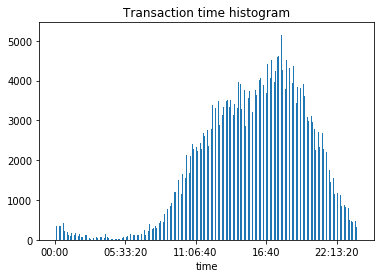

In [107]:
time, customers = np.unique(transaction_df.trans_time.sort_values(), return_counts=True)
plt.bar(time, customers, width=30)
plt.title("Transaction time histogram")
plt.show()

*comment:*
> The amount of transaction reach a first *local maximum* around noon and the global maximum around 5p.m. which is intuitive. Indeed, people go shopping either during lunch time or after work.

In [108]:
transaction_df

day  quantity  sales_value  store_id  \
household_key basket_id   product_id                                         
2375          26984851472 1004906       1         1         1.39       364   
                          1033142       1         1         0.82       364   
                          1036325       1         1         0.99       364   
                          1082185       1         1         1.21       364   
                          8160430       1         1         1.50       364   
...                                   ...       ...          ...       ...   
1598          42305362535 92130       711         1         0.99      3228   
                          114102      711         1         8.89      3228   
                          133449      711         1         6.99      3228   
                          6923644     711         1         4.50      3228   
                          14055192    711         1         6.99      3228   

                                      retail_disc trans_time  week_no  \
household_key basket_id   product_id                                    
2375          26984851472 1004906           -0.60   16:31:00        1   
                          1033142            0.00   16:31:00        1   
                          1036325           -0.30   16:31:00        1   
                          1082185            0.00   16:31:00        1   
                          8160430           -0.39   16:31:00        1   
...                                           ...        ...      ...   
1598          42305362535 92130              0.00   15:20:00      102   
                          114102             0.00   15:20:00      102   
                          133449             0.00   15:20:00      102   
                          6923644           -0.49   15:20:00      102   
                          14055192           0.00   15:20:00      102   

                                      coupon_disc  coupon_match_disc  
household_key basket_id   product_id                                  
2375          26984851472 1004906             0.0                0.0  
                          1033142             0.0                0.0  
                          1036325             0.0                0.0  
                          1082185             0.0                0.0  
                          8160430             0.0                0.0  
...                                           ...                ...  
1598          42305362535 92130               0.0                0.0  
                          114102              0.0                0.0  
                          133449              0.0                0.0  
                          6923644             0.0                0.0  
                          14055192            0.0                0.0  

[2595732 rows x 9 columns]

In [109]:
# household vs days (bias ?)

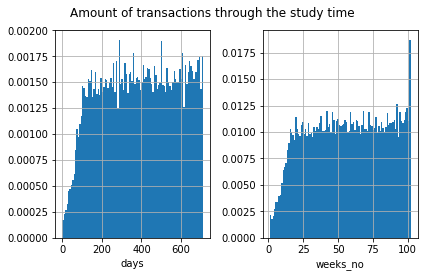

In [110]:
fig, axes = plt.subplots(1, 2)
transaction_df.day.hist(bins=100, ax=axes[0], density=True)
axes[0].set_xlabel("days")
transaction_df.week_no.hist(bins=100, ax=axes[1], density=True)
axes[1].set_xlabel("weeks_no")
plt.suptitle("Amount of transactions through the study time")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

*comment:*
1. We see an increasing phase of transactions during the first 100 days (15 weeks). This suggests that data collection was "on-flight" or that data sampling was not gathered properly.
2. Thus, we decide to build a new transaction dataframe where we cut the transactions before this date. We will us it for applications where it could potentially induce bias.
3. A whole section will deal bias later in the the process.

**Discount related**

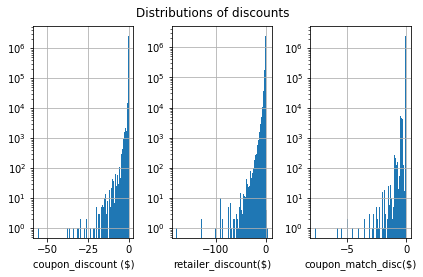

In [111]:
fig, axes = plt.subplots(1, 3)
plt.suptitle("Distributions of discounts")
transaction_df.coupon_disc.hist(bins=100, ax=axes[0])
axes[0].set_xlabel("coupon_discount ($)")
axes[0].set_yscale('log')
transaction_df.retail_disc.hist(bins=100, ax=axes[1])
axes[1].set_xlabel("retailer_discount($)")
axes[1].set_yscale('log')
transaction_df.coupon_match_disc.hist(bins=100, ax=axes[2])
axes[2].set_xlabel("coupon_match_disc($)")
axes[2].set_yscale('log')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

*comment:*
> We observe the dicount: it is sharply distributed close to 0.

**Quantities related**:

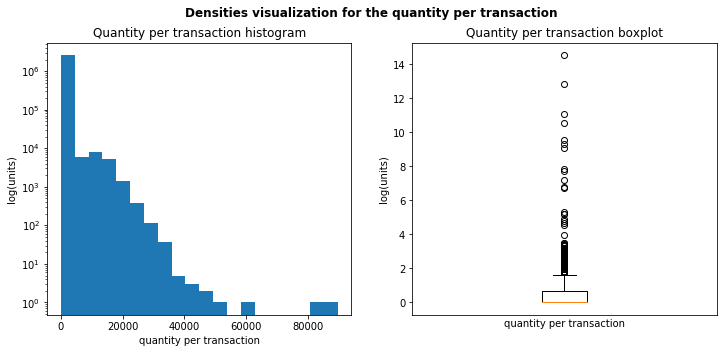

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("Densities visualization for the quantity per transaction", fontweight='bold')

axes[0].hist(transaction_df.quantity, log=True, bins=20)
axes[0].set_title("Quantity per transaction histogram")
axes[0].set_xlabel("quantity per transaction")
axes[0].set_ylabel("log(units)")

axes[1].boxplot(np.log(transaction_df.quantity.value_counts()))
axes[1].set_xticks([0])
axes[1].set_title("Quantity per transaction boxplot")
axes[1].set_ylabel("log(units)")
axes[1].set_xlabel("quantity per transaction")

plt.show()

*comment:*
1. Both figures (histogram and boxplot) show that the largest part of quantities exchange per transaction is less than 20 units.
2. The median is really close to 1 (log10(units)) meaning that 50% of the quantity per transaction is less than 10.
3. The boxplot shows us that there is a lot of outliers. We will investigate on that later in the outliers part. We suppose that some items are quantified differently.

In [113]:
count, qty = np.histogram(transaction_df.quantity)

**Sales value related:**

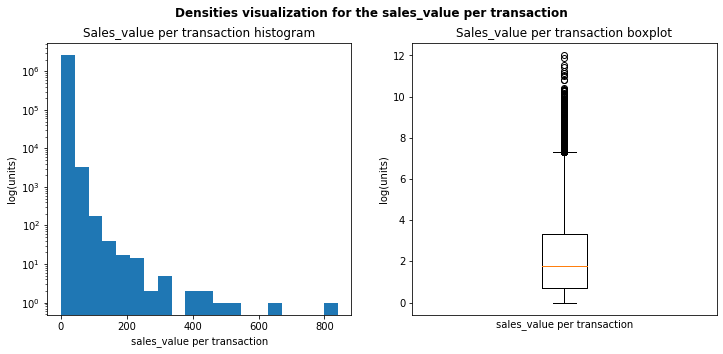

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("Densities visualization for the sales_value per transaction", fontweight='bold')

axes[0].hist(transaction_df.sales_value, log=True, bins=20)
axes[0].set_title("Sales_value per transaction histogram")
axes[0].set_xlabel("sales_value per transaction")
axes[0].set_ylabel("log(units)")

axes[1].boxplot(np.log(transaction_df.sales_value.value_counts()))
axes[1].set_xticks([0])
axes[1].set_title("Sales_value per transaction boxplot")
axes[1].set_ylabel("log(units)")
axes[1].set_xlabel("sales_value per transaction")

plt.show()

*comment:*
1. The densities are similar as the quantity feature in the sense that they have similar shape with many outliers.
2. However the whiskers from sales_value are in wider range than quantity feature.
3. All that suggests that outliers from the quantity feature and those from sales_value are related. As stated previously, we will investigate on that later on.

**store id:**

In [115]:
unique_stores = np.unique(transaction_df.store_id.values)
print(f"Number of unique stores: {len(unique_stores)}")

Number of unique stores: 582


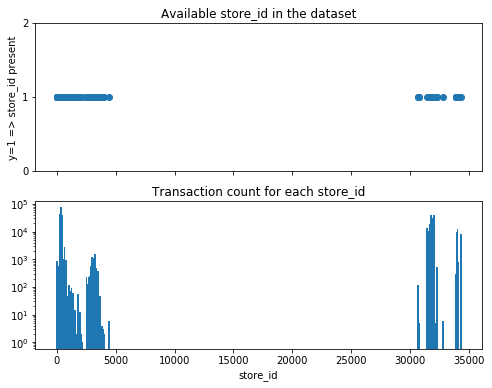

In [116]:
# here we want to evaluate what are the stores who have the higher amount of transactions
transaction_per_store = transaction_df.store_id.value_counts().sort_index()

fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
plt.suptitle("")
axes[0].scatter(unique_stores, [1 for i in range(len(unique_stores))])
axes[0].set_yticks(range(3))
axes[0].set_title("Available store_id in the dataset")
axes[0].set_ylabel("y=1 => store_id present")

axes[1].bar(transaction_per_store.index, transaction_per_store.values, width=150)
axes[1].set_title("Transaction count for each store_id")
axes[1].set_yscale('log')
plt.xlabel("store_id")
plt.show()

*comment:*
1. From fig1 we observe that there is two clusteres of stores id ([0, 5000], [30000, 35000]). If we assume that store_id are given from geographical position, we could say that this dataset is taken from two different regions.
2. In this two cluster some stores have a lot of transactions and some have much less. This could suggest two main explainations:
> * Either this is due to bad sampling routine. In this case we should be really attentive to any bias in the dataset.
> * Or it could be the fact of different size of shopping centers and then we should simply remove small shopping centers when the application asks for it.
> * The stores were sorted according to some criterion. We see that there are about 4 groups with differnet transaction amounts

<a id=d_demo></a>
#### Demographic

In [117]:
def print_cat_bar(df):
    df_cat = df.select_dtypes(include='category')
    fig = plt.figure(figsize=(10, 15))
    cols = df_cat.columns
    columns = 2
    rows = len(cols) / columns + 1

    for i in range(0, len(cols)):
        ax = fig.add_subplot(rows, columns, i+1)
        sns.countplot(data=df_cat, x=cols[i], ax=ax)
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            
    return fig

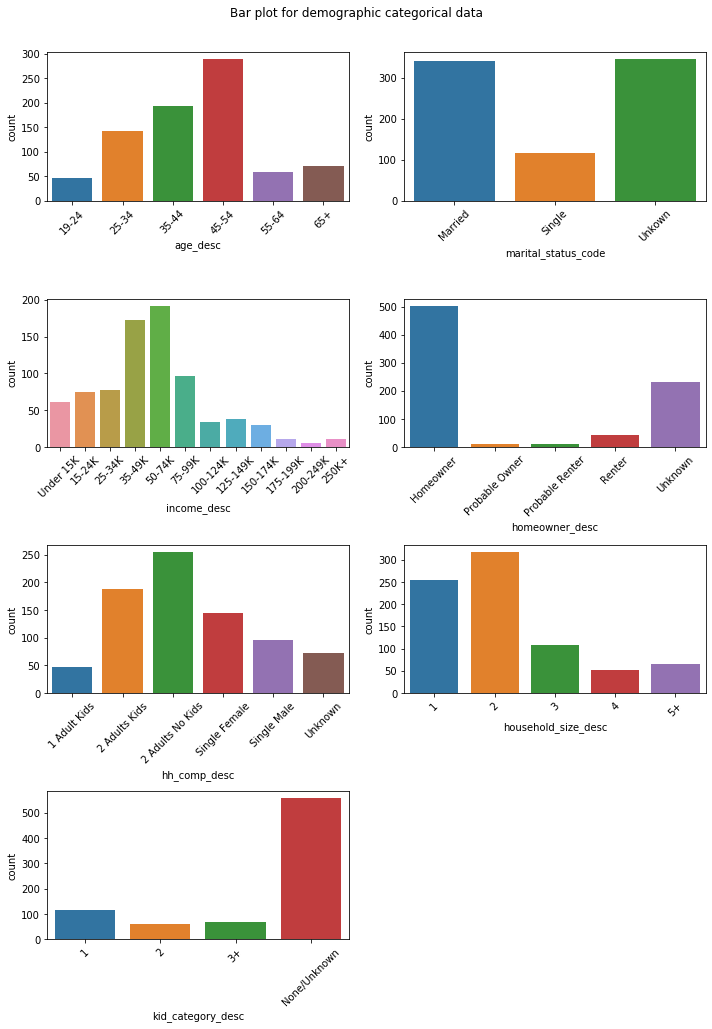

In [118]:
fig = print_cat_bar(demographic_df)
fig.axes[1].set_xticklabels(('Married', 'Single', 'Unkown'))
fig.suptitle("Bar plot for demographic categorical data")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

*Comment:*
1. As the figures above suggest it, the typical houshold in this dataset:
    * is between 25 and 54 years old
    * is married
    * has a median salary (between 35k and 74k per year)
    * is homeowner
    * is composed of 2 adults with few are no children
2. An ideal data sampling would have select more uniformly the data two draw conclusion on the general population. We could find some reason to this non uniform data sampling
    * This dataset is on marketing purpose. They wanted to target people in a wiser manner. Thus, it is likely they chose the most interesting people for them to increase their benefits **=> middle class households**
    * They recruit people on voluntary basis and could not chose equilibrated household compositions.
   

<a id=d_prod></a>
#### Products

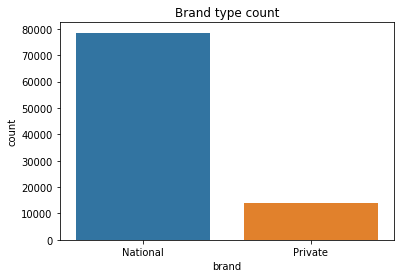

In [119]:
sns.countplot(x='brand', data=product_df)
plt.title("Brand type count")
plt.show()

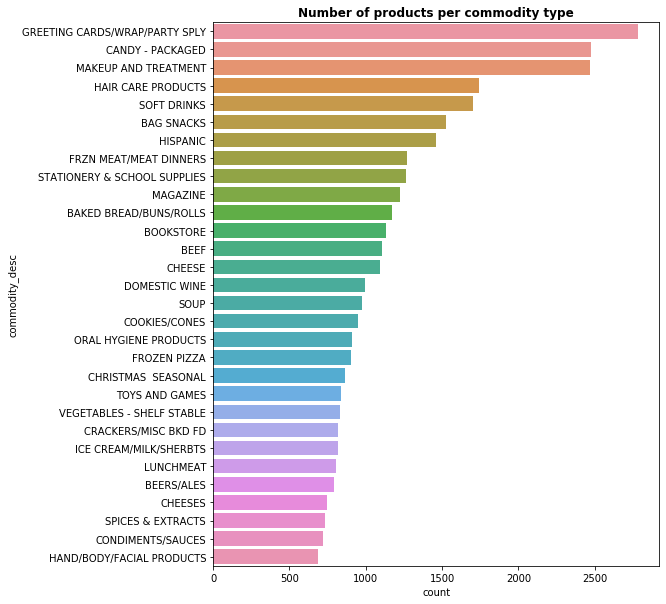

In [120]:
# Display the amount of available products per commodity type
plt.figure(figsize=(8, 10))
sns.countplot(y='commodity_desc', data=product_df, order=product_df['commodity_desc'].value_counts().iloc[:30].index)
plt.tick_params(axis='y')
plt.title("Number of products per commodity type", fontweight='bold')
plt.show()

<a id=outliers></a>
### Outliers analysis

In [149]:
transaction_data_df[transaction_data_df['quantity']>150].join(product_df,on='product_id')['sub_commodity_desc'].unique()

[GASOLINE-REG UNLEADED]
Categories (1, object): [GASOLINE-REG UNLEADED]

Here we see that the outliers in the quantity is because the gasoline quantity is measured differently!

### Dealing with bias

**TODO**

<a id=explo></a>
# 3. Exploitation

## A. Specific preprocessing

## B. Nutrient module

In [122]:
health_df = pd.read_pickle('../results/products_with_link_to_nutrients_df.pickle')
trans_count_df = transaction_df.groupby('product_id').agg(count=('quantity', 'count')).sort_values(by='count', ascending=False)
health_df = trans_count_df.merge(health_df,left_index = True,right_index = True,how = 'inner')

In [123]:
health_df.head(1)

,count,CURR_SIZE_OF_PRODUCT,QUANTITY,ingredients,ref_fdc_name,cholesterol,energy,fatty acids total monounsaturated,fatty acids total polyunsaturated,fatty acids total saturated,fiber,protein,sodium,sugars,total lipid,vitamin a,vitamin b-12,vitamin b-6,vitamin e,vitamin k
1082185,29778,40 LB,30896,"[tropical, fruit, bananas]","[tropical, fruit, cocktail, cooked, light, syrup]",0.0,57.0,0.014,0.031,0.01,1.0,0.4,6.0,13.93,0.07,10.0,0.0,0.051,0.0,2.6


In [124]:
#The nutrition section just got ready: many plots to come soon.

## C. Time series analysis

### C.1 Find out season with time anonymised data

### C.2 Find out high rate sold product throughout the day

### C.3 Trending products

## D. Influence of demographic factors on shopping habits.

If we want to compare shopping amounts amongst households, we must deal with the fact that they don't purchase at the same frequency or times. We can compare the shopping rate amongst households by taking the ratio of the cummulative expenditure of a household and the number of days over which they occured.

### Preprocessing:  
We will append purchases, savings and days into a list per household

In [125]:
# add two columns. One with paid price and one with total savings
transaction_df['paid_price'] = transaction_df.sales_value+ \
                                    transaction_df.retail_disc+\
                                    transaction_df.coupon_disc+\
                                    transaction_df.coupon_match_disc

transaction_df['total_savings'] = abs(transaction_df.retail_disc+\
                                           transaction_df.coupon_disc+\
                                           transaction_df.coupon_match_disc)
#transaction_data_df.head(3)

In [126]:
# turn the days of purchase into a list on a single row
days_purchased_each_house=transaction_df.groupby(['household_key','day','store_id'])['paid_price']\
.sum()\
.reset_index()\
.set_index('household_key')\
.groupby('household_key')['day'].apply(list)
#days_purchased_each_house.head(2)

In [127]:
#Compute daily paid prices and daily savings, and then turn them into a list 
transaction_val_each_house=transaction_df.groupby(['household_key','day','store_id'])['paid_price','total_savings']\
.sum()\
.reset_index()\
.set_index('household_key')\
.groupby('household_key')['paid_price','total_savings']\
.agg({'paid_price': lambda x: [round(i,2) for i in x.tolist()],'total_savings': lambda x: [round(i,2) for i in x.tolist()]})
#transaction_val_each_house.head()


In [128]:
#merge the two series on household key
transaction_freq_df = pd.merge(transaction_val_each_house,days_purchased_each_house,\
                               left_on='household_key',right_on='household_key')
transaction_freq_df['day']=transaction_freq_df['day'].apply(lambda x: np.array(x))
transaction_freq_df.head()

,paid_price,total_savings,day
household_key,,,
1,"[61.12, 32.51, 20.18, 50.35, 37.03, 19.52, 19....","[17.54, 8.59, 6.72, 13.08, 16.42, 7.24, 3.97, ...","[51, 67, 88, 94, 101, 108, 111, 128, 137, 146,..."
2,"[3.43, 3.48, 11.06, 23.55, 22.26, 28.02, 24.83...","[19.27, 0.9, 1.78, 7.3, 4.68, 4.21, 9.63, 0.51...","[103, 112, 117, 118, 121, 139, 140, 147, 154, ..."
3,"[39.69, 19.99, 28.21, 1.82, 77.98, 15.78, 8.02...","[7.12, 1.46, 46.22, 0.18, 43.56, 0.0, 3.96, 12...","[113, 121, 136, 139, 141, 142, 163, 166, 169, ..."
4,"[96.33, 118.12, 31.09, 60.5, 6.14, 107.95, 60....","[29.91, 5.66, 0.66, 2.09, 1.2, 8.78, 8.06, 3.1...","[104, 140, 154, 181, 190, 199, 216, 231, 244, ..."
5,"[4.48, 3.69, 12.29, 39.43, 45.13, 0.5, 12.01, ...","[0.0, 1.85, 1.39, 20.61, 13.36, 0.0, 2.4, 14.4...","[85, 87, 88, 97, 111, 131, 138, 154, 168, 181,..."


### Compute purchase rate, savings rate:
We will add up all the entries per list and divide by the days spanned. 

In [129]:
# Compute the purchase rate 
def compute_rate(df,column='paid_price'):
    
    #Compute cumulative sum of desired column value
    cum_value = np.sum(df[column])
    
    #subtract last day from first day
    x = np.array(df['day'])
    
    if (x[-1]-x[0])==0: #we filter out single days
        value_rate = np.nan
    
    else:
        value_rate = cum_value/(x[-1]-x[0])
    
    return value_rate

In [130]:
#get purchase rate and savings rate series
purchase_rate=transaction_freq_df.apply(lambda x: compute_rate(x,'paid_price'),axis=1)
savings_rate = transaction_freq_df.apply(lambda x: compute_rate(x,'total_savings'),axis=1)

In [131]:
# join 2 series 
rates = pd.concat([purchase_rate, savings_rate], axis=1)
rates.columns=['purchase_rate','savings_rate']

### Distribution of purchase and savings rate:
Let's observe the distribution of these 2 quantities to ensure there are no outliers

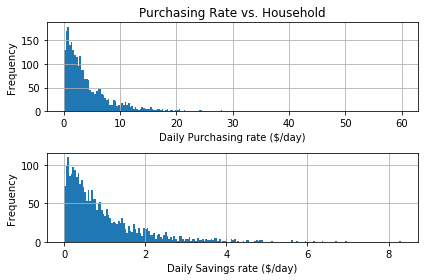

In [132]:
#observe distribution of purchase rate and savings rate
f, (ax1, ax2) = plt.subplots(2, 1)
purchase_rate.hist(bins=200,ax=ax1)
savings_rate.hist(bins=200,ax=ax2)
ax1.set_title('Purchasing Rate vs. Household')
ax1.set_xlabel('Daily Purchasing rate ($/day)')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Daily Savings rate ($/day)')
plt.tight_layout()

We see that on a daily basis the households tend to spend about 4 dollars and save about 1 dollar. Let us now see how these quantities relate to household demographics

### Compare with Demographic Data:
We will look at household size, income description, and age

#### Household size

In [133]:
#Merge with demographic df, groupby household size, and compute mean and std
demographic_df.join(rates,on='household_key').\
groupby('household_size_desc')['purchase_rate','savings_rate'].agg(['mean','std'])

purchase_rate           savings_rate          
                             mean       std         mean       std
household_size_desc                                               
1                        6.439627  4.375503     1.378191  1.004146
2                        7.225627  4.722696     1.517779  0.947449
3                        7.840936  5.813920     1.725835  1.323227
4                        8.403178  5.373897     1.978823  1.152074
5+                       8.496522  6.973049     1.828901  1.163756

In [134]:
demographic_df.join(rates,on='household_key').\
groupby('household_size_desc')['purchase_rate','savings_rate']\
.describe()[('purchase_rate','count')]\
.rename('group sizes')

household_size_desc
1     255.0
2     318.0
3     109.0
4      53.0
5+     66.0
Name: group sizes, dtype: float64

We see that the purchase rates increases slightly with household size as expected, but the standard deviations are too high to conclude a significant correlation. We most also be aware that each group size is different, but they're all larger than 50, which should be high enough.  

#### Income Description

Since the income description distribution is very uneven, it is not a good idea to compare averages and standard deviations. Instead, a box plot could be more revealing.

In [135]:
# create dataframe only with income description purchase rate and savings rate
r_df = demographic_df.join(rates,on='household_key')[['income_desc','purchase_rate','savings_rate']]
r_df.head()

,income_desc,purchase_rate,savings_rate
household_key,,,
1,35-49K,5.383832,1.227099
7,50-74K,4.201152,0.755190
8,25-34K,6.905569,1.729329
13,75-99K,18.384227,3.311365
16,50-74K,2.263057,0.291030


Text(0.5, 0, 'Income Description')

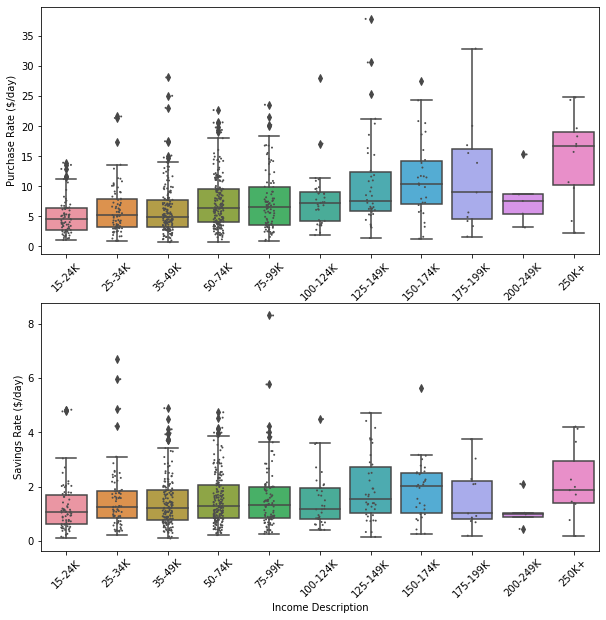

In [136]:
#specify order of boxes in boxplot
order = ['250K+','200-249K','175-199K','150-174K','125-149K','100-124K','75-99K','50-74K','35-49K','25-34K','15-24K']
order = [o for o in reversed(order)]
#do a box plot
f,(ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
p1=sns.stripplot(x=r_df.income_desc, y=r_df.purchase_rate, data=r_df,order=order,size=2,color='.3',ax=ax1)
p1.set_xticklabels(p1.get_xticklabels(),rotation=45)
p1 = sns.boxplot(x=r_df.income_desc, y=r_df.purchase_rate, data=r_df,order=order,ax=ax1)
p1.set_ylabel('Purchase Rate ($/day)')
p1.set_xlabel('Income Description')

p2=sns.stripplot(x=r_df.income_desc, y=r_df.savings_rate, data=r_df,order=order,size=2,color='.3',ax=ax2)
p2.set_xticklabels(p2.get_xticklabels(),rotation=45)
p2 = sns.boxplot(x=r_df.income_desc, y=r_df.savings_rate, data=r_df,order=order,ax=ax2)
p2.set_ylabel('Savings Rate ($/day)')
p2.set_xlabel('Income Description')



While purchase rate seems to be correlated with income, the savings rate does not seem to vary significantly accross income groups. Moreover, we see how smaller datapoints generate a large spread in the high-income groups.

#### Age description

In [137]:
demographic_df.join(rates,on='household_key')\
.groupby('age_desc')['purchase_rate','savings_rate']\
.agg(['mean','std']).sort_values(('purchase_rate','mean'),ascending=False)

purchase_rate           savings_rate          
                  mean       std         mean       std
age_desc                                               
35-44         8.203280  5.451036     1.782803  1.285867
45-54         7.406318  5.449886     1.629978  1.115170
25-34         7.144180  4.755631     1.404635  0.853282
55-64         6.435791  4.326053     1.492947  0.792084
19-24         6.074516  3.873347     1.336504  0.838325
65+           5.591479  3.620345     1.159371  0.727598

We observe that the purchase rate peaks between the ages 35-44 and drops at 65+ years old. This is an intuitive result since at 35 most people are starting families and active workers. We observe that similar to household size, the group sizes are different but they're all larger than 50. 

## E. Top bought item per household

In this section we'll observe what kind of products are bought the most by joining the product dataframe with the transaction dataframe. Since our project will focus on food, we decided to focus on the 'grocery' department of the products, which includes all the foods and drinks. We will also look at the commodity description which is the most general description of the product. 

In [138]:

# merge transaction df with product df
transaction_product_id_df = transaction_df.reset_index()[['household_key','product_id','quantity','sales_value','day']]\
.merge(product_df[['manufacturer','department','commodity_desc','sub_commodity_desc','curr_size_of_product']]\
       ,left_on='product_id',right_index=True,how='left')

In [139]:
# Filter out departments that contain food items
food_df =  transaction_product_id_df[transaction_product_id_df['department']\
                                     .isin(['NUTRITION', 'GROCERY', 'PASTRY',
                                     'MEAT-PCKGD', 'SEAFOOD-PCKGD','PRODUCE',
                                     'DELI','MEAT', 'SALAD BAR','GRO BAKERY',
                                     'FROZEN GROCERY', 'SPIRITS', 'RESTAURANT'])]

Text(0, 0.5, '# households')

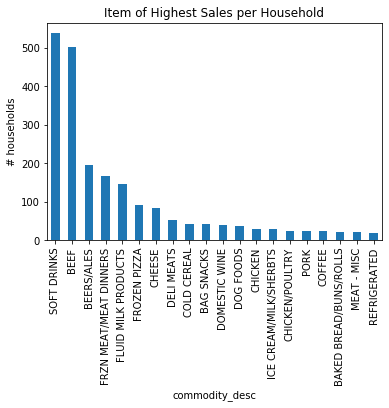

In [140]:
# rank items per sales value per household. 
# we take top sales-value item per household and aggregate it by count 
food_df\
.groupby(['household_key','commodity_desc'])[['sales_value','quantity']]\
.sum().sort_values(['household_key','sales_value'],ascending=False).reset_index()\
.groupby('household_key').first().reset_index()\
.groupby('commodity_desc')['household_key'].count()\
.sort_values(ascending=False).head(20).plot.bar(rot=90)

ax = plt.gca()
ax.set_title('Item of Highest Sales per Household')
ax.set_ylabel('# households')

We see that in the food departments, the items that have largest sales values per household are mainly soft drinks and beef. Perhaps these groups dominate because they are the most expensive per unit. 

### Top 2 products per household: 2d histogram 

The first step is to get top 2 highest-sales value items per household. Then mapping the unique commodity descriptions to numerical values in order to plot them in a 2d histogram. Lastly, the numerical values can be replaced with original labels

In [141]:
# Take 2 top sales_value item per household
top_purchased_foods= food_df.\
groupby(['household_key','commodity_desc'])[['sales_value','quantity']].\
sum().sort_values(['household_key','sales_value'],ascending=False).reset_index().\
groupby('household_key').head(2).reset_index()
top_purchased_foods.head()

,index,household_key,commodity_desc,sales_value,quantity
0,0,2500,BEERS/ALES,302.17,23.0
1,1,2500,CHEESE,142.34,77.0
2,308,2499,FROZEN PIZZA,164.99,78.0
3,309,2499,BAG SNACKS,125.42,57.0
4,616,2498,FLUID MILK PRODUCTS,177.67,70.0


In [142]:
# make dictionary mapping commodity desc to a numerical value for the 2d histogram
unique_com_desc = top_purchased_foods.commodity_desc.unique()
num_to_desc = dict(enumerate(unique_com_desc))
desc_to_num = {v: k for k, v in num_to_desc.items()}

In [143]:
top_purchased_foods.replace({'commodity_desc':desc_to_num},inplace=True)

In [144]:
top_purchased_foods.drop(['sales_value','quantity'],axis=1,inplace=True)

In [145]:
top_purchased_foods = pd.pivot_table(top_purchased_foods,index=['household_key'],\
             columns=top_purchased_foods\
               .groupby(['household_key'])\
             .cumcount().add(1),values=['commodity_desc'],aggfunc='sum')
top_purchased_foods.columns=  top_purchased_foods.columns.map('{0[0]}{0[1]}'.format) 
top_purchased_foods.head(3)

,commodity_desc1,commodity_desc2
household_key,,
1,14,5
2,5,20
3,6,5


In [146]:
# drop any nans which could come from families that had single transactions with only one product
top_purchased_foods.dropna(how='any',inplace=True)

Text(0, 0.5, '2nd Top Sales-Value Product')

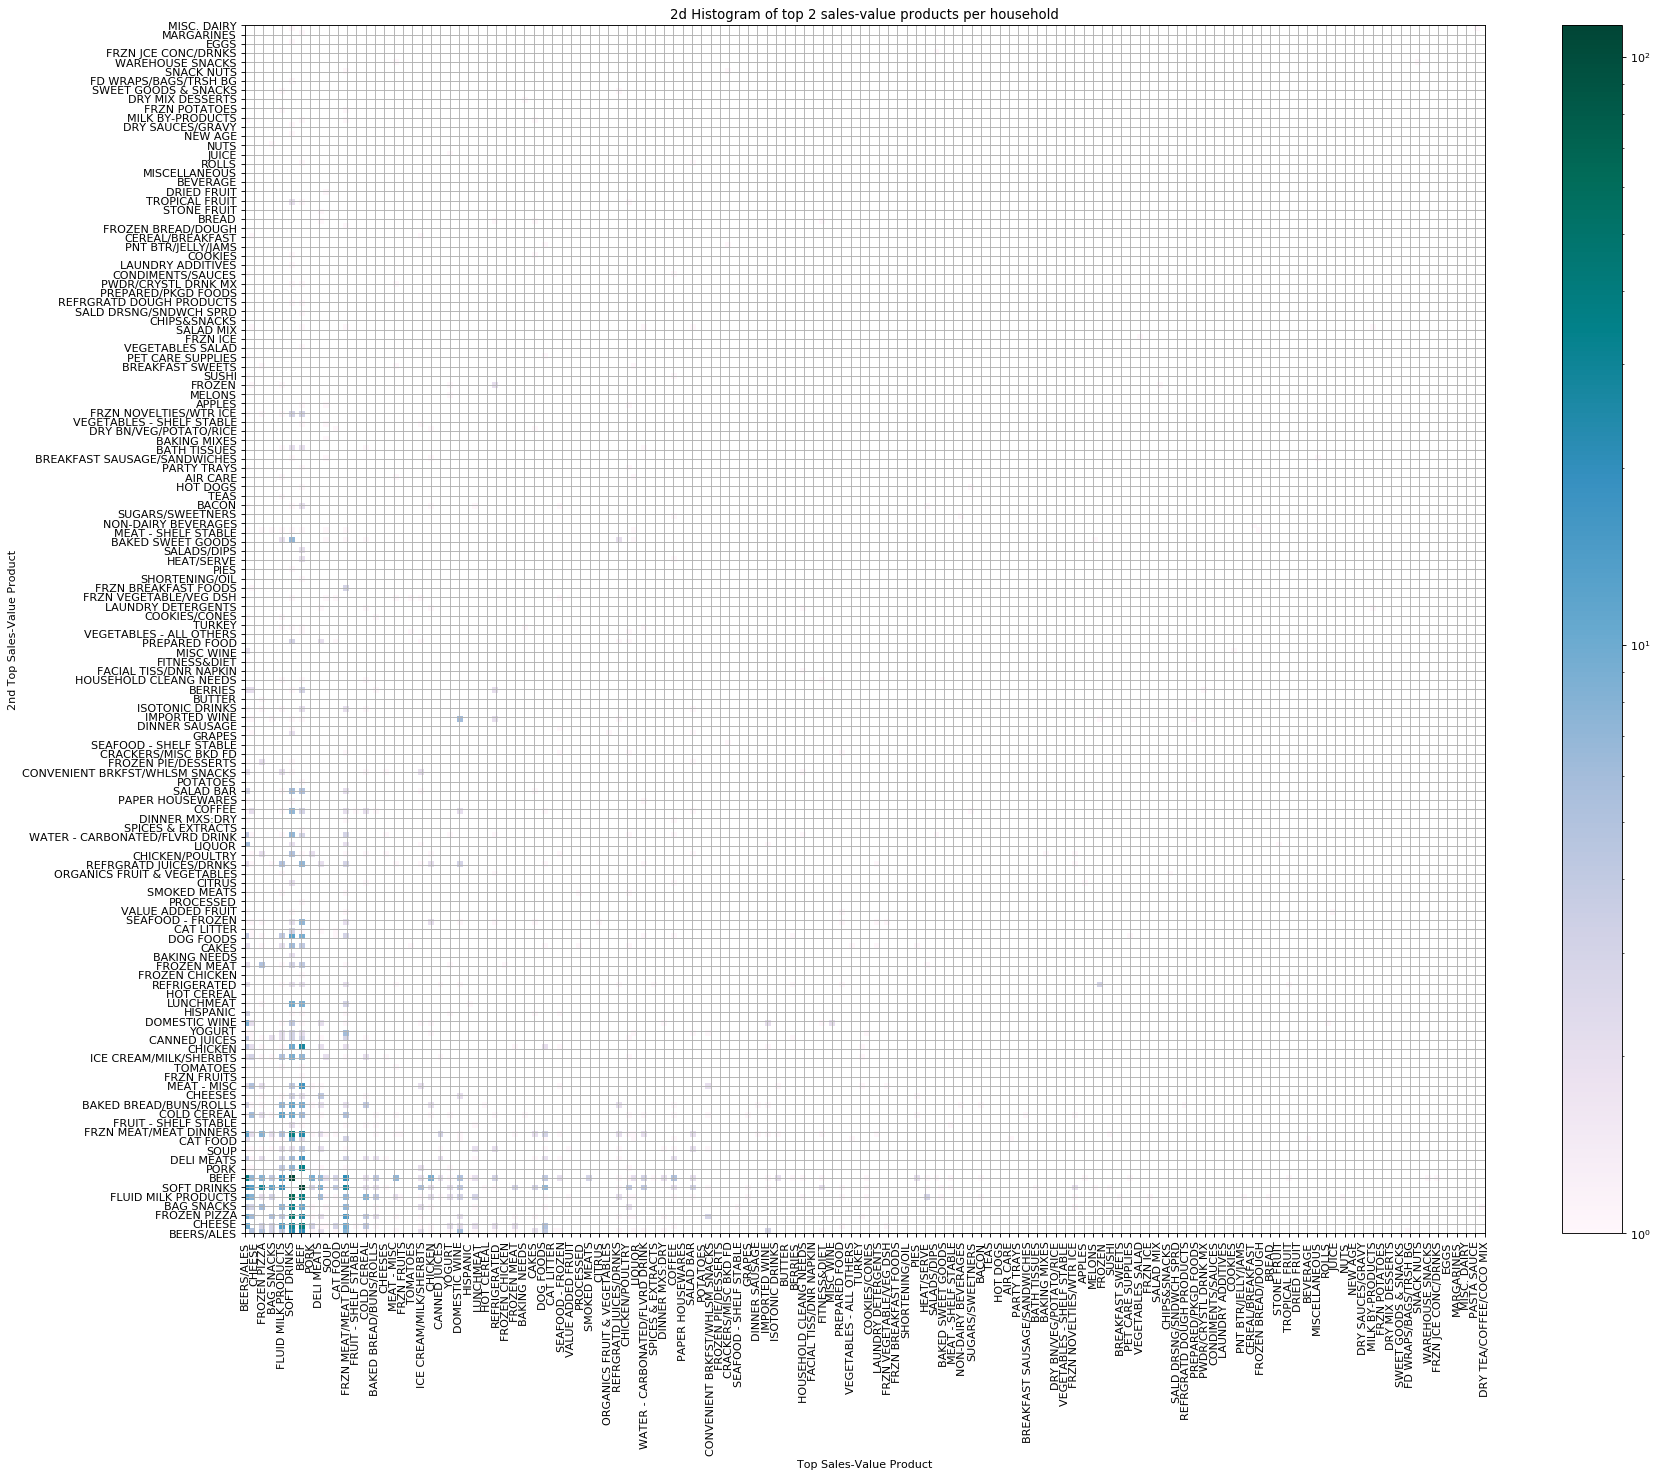

In [147]:
from matplotlib.colors import LogNorm
#fig, ax = plt.subplots(1,1)
plt.figure(num=None, figsize=(25, 20), dpi=80, facecolor='w', edgecolor='k')
# Set ticks labels for x-axis
plt.xticks(range(np.size(unique_com_desc)),num_to_desc.values(), rotation=90)
plt.yticks(range(np.size(unique_com_desc)),num_to_desc.values())
ax = plt.gca()
counts, xedges, yedges, im = ax.hist2d(top_purchased_foods.commodity_desc1, top_purchased_foods.commodity_desc2, bins=250,cmap='PuBuGn',norm=LogNorm())
plt.colorbar(im, ax=ax)
plt.grid(True)
plt.title('2d Histogram of top 2 sales-value products per household')
plt.xlabel('Top Sales-Value Product')
plt.ylabel('2nd Top Sales-Value Product')

From this plot we see that the top products per household include soft-drinks, cheese, frozen pizza, bag snacks, beef, pork and chicken which are the top items of household. Some other products such as eggs or vegetables appear as top products in only ~10 of the 2500 households. 

## F. Predict marital status and household composition

## G. Obesity detection